In [1]:
from PIL import Image, ImageDraw, ImageFont
import torch as th
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from functools import lru_cache
import requests
from io import BytesIO

import requests
from PIL import Image
from io import BytesIO
from functools import lru_cache

# sdxl_vae.config.scaling_factor
challenge_images = [
    "https://i.redd.it/rw7g1xmvx1wc1.jpeg",  # cosplayers
    "https://www.takewalks.com/blog/wp-content/uploads/2023/06/walks_sf_day_01.jpg",  # chinatown
    "https://i.redd.it/ktzyxj3prjz81.jpg",  # flowers, painful colors
    "https://static01.nyt.com/images/2018/10/05/us/05sfbuildings/merlin_136702875_6d0ee402-e952-4402-b5b3-d2a2d8668147-superJumbo.jpg",  # lots of buildings
    "https://i.redd.it/zm4px3hvggj51.jpg",  # "", # magazines, brutal text
    "https://sun9-66.userapi.com/impg/wXQVMfkuyg8rCrVwsbAkZyaU7PX-MlpQ1R8kiA/EbA5ZkhXCn8.jpg?size=1280x861&quality=95&sign=5bd46a50ad1440555d1bf6cf0095dacf&c_uniq_tag=meAZjmpctpI7dDLIpZpOyJaGSvnYBL-Yb2TEGkOq62w&type=album"
]

challange_images_name = {
    "cosplayers": "https://i.redd.it/rw7g1xmvx1wc1.jpeg",
    "chinatown": "https://www.takewalks.com/blog/wp-content/uploads/2023/06/walks_sf_day_01.jpg",
    "flowers": "https://i.redd.it/ktzyxj3prjz81.jpg",
    "buildings": "https://static01.nyt.com/images/2018/10/05/us/05sfbuildings/merlin_136702875_6d0ee402-e952-4402-b5b3-d2a2d8668147-superJumbo.jpg",
    "magazines": "https://i.redd.it/zm4px3hvggj51.jpg",
    "faces": "https://sun9-66.userapi.com/impg/wXQVMfkuyg8rCrVwsbAkZyaU7PX-MlpQ1R8kiA/EbA5ZkhXCn8.jpg?size=1280x861&quality=95&sign=5bd46a50ad1440555d1bf6cf0095dacf&c_uniq_tag=meAZjmpctpI7dDLIpZpOyJaGSvnYBL-Yb2TEGkOq62w&type=album"
}
import os

# too easy
# "https://preview.redd.it/itap-of-a-abandoned-house-v0-ydm9ym48uofb1.jpg?auto=webp&s=42917a397f42ba6f7b5fc7ad041ebb910d12a8f1",
# "https://www.jocooks.com/wp-content/uploads/2023/07/berry-tart-1-10.jpg",


def load_image_from_url(name):
    url = challange_images_name[name]
    try:
        # check if the image exists in contents.
        if os.path.exists(f"contents/{name}.jpg"):
            image = Image.open(f"contents/{name}.jpg")
            print(f"Loaded {name} from contents.")
        else:
            # Send a GET request to the URL
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes

            # Create a Pillow Image object from the response content
            image = Image.open(BytesIO(response.content))
            # also save the image to contents.
            image.save(f"contents/{name}.jpg")

        image = TF.center_crop(TF.resize(image, 256, TF.InterpolationMode.BICUBIC), 256)
        return image

    except requests.RequestException as e:
        print(f"Error fetching the image: {e}")
        raise
    except Image.UnidentifiedImageError:
        print("The URL does not point to a valid image file.")
        raise


# for im_url in challenge_images:
#     # print(im_url)
#     display(load_image_from_url(im_url))
challenge_tensors = [
    TF.to_tensor(load_image_from_url(name)) for name in challange_images_name
]

Loaded cosplayers from contents.
Loaded chinatown from contents.
Loaded flowers from contents.
Loaded buildings from contents.
Loaded magazines from contents.
Loaded faces from contents.


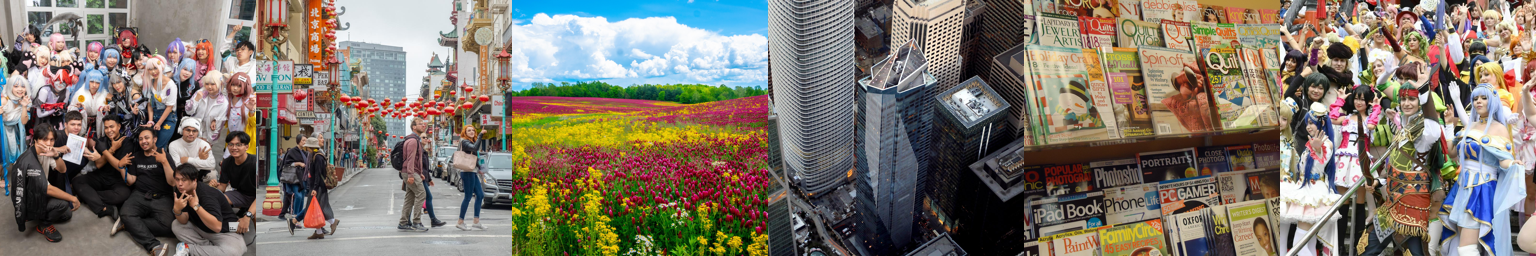

In [2]:
display(TF.to_pil_image(th.cat(challenge_tensors, -1)))

In [3]:
import torch
from diffusers import AutoencoderKL

sdxl_vae = (
    AutoencoderKL.from_pretrained(
        "madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16
    )
    .to("cuda")
    .requires_grad_(False)
)

In [4]:
import torch
from diffusers import AutoencoderKL

ai_vae = (
    AutoencoderKL.from_pretrained(
        "AiArtLab/sdxl_vae", torch_dtype=torch.float16
    )
    .to("cuda")
    .requires_grad_(False)
)

In [6]:
import torch
from diffusers import AsymmetricAutoencoderKL

aiasym_vae = (
    AsymmetricAutoencoderKL.from_pretrained(
        "AiArtLab/sdxl_vae", subfolder="asymmetric_vae_new", torch_dtype=torch.float16
    )
    .to("cuda")
    .requires_grad_(False)
)

config.json:   0%|          | 0.00/823 [00:00<?, ?B/s]

asymmetric_vae_new/diffusion_pytorch_mod(…):   0%|          | 0.00/421M [00:00<?, ?B/s]

The config attributes {'block_out_channels': [128, 256, 512, 512], 'force_upcast': False} were passed to AsymmetricAutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [7]:
@lru_cache
def get_font(bold=True, size=32):
    if bold:
        font_url = "https://github.com/openmaptiles/fonts/raw/master/noto-sans/NotoSans-Bold.ttf"
    else:
        font_url = "https://github.com/openmaptiles/fonts/raw/master/noto-sans/NotoSans-Regular.ttf"
    font_response = requests.get(font_url)
    font_data = BytesIO(font_response.content)
    font = ImageFont.truetype(font_data, size)
    return font


def render_title_image(label, width, height, py=0, px=0):
    im_out = Image.new("RGB", (width, height))
    draw = ImageDraw.Draw(im_out)
    # draw.text((px, 8), label + " Latent Modification Chart", font=get_font(bold=True, size=64), fill=(255, 255, 255))
    draw.text((px, py), label, font=get_font(bold=True, size=24), fill=(255, 255, 255))
    # draw.text((px, 8 + 96), f"Image-space effects of various modifications to the {label} latents.", font=get_font(bold=True), fill=(127, 127, 127))
    return TF.to_tensor(im_out)


def render_column(label, ims, pad=8, inset_size=48, inset_scale=2, inset_offsets=None):
    title = render_title_image(
        label, width=ims.shape[-1] + pad * 2, height=64, py=16, px=pad
    )

    iy = (ims.shape[-2] - inset_size) // 2
    ix = (ims.shape[-1] - inset_size) // 2
    inset = F.interpolate(
        th.stack(
            [
                im[:, oy + iy : oy + iy + inset_size, ox + ix : ox + ix + inset_size]
                for im, (oy, ox) in zip(ims, inset_offsets)
            ],
            0,
        ),
        scale_factor=inset_scale,
    )

    ims = F.pad(ims, (pad,) * 4)

    ims[:, :, -inset.shape[-2] - pad // 2 :, -inset.shape[-1] - pad // 2 :] *= 0
    ims[:, :, -inset.shape[-2] :, -inset.shape[-1] :] = inset
    # render inset
    return th.cat([title] + list(ims), -2)


def make_header_image(label, width=512, height=96, py=64, px=16):
    im_out = Image.new("RGB", (width, height))
    draw = ImageDraw.Draw(im_out)
    # draw.text((px, 8), label + " Latent Modification Chart", font=get_font(bold=True, size=64), fill=(255, 255, 255))
    draw.text((px, 8), label, font=get_font(bold=True, size=64), fill=(255, 255, 255))
    # draw.text((px, 8 + 96), f"Image-space effects of various modifications to the {label} latents.", font=get_font(bold=True), fill=(127, 127, 127))
    return TF.to_tensor(im_out)


@th.no_grad()
def render_challenge_image_(vaes, image_list, inset_offsets, title):
    im = th.stack(image_list, 0)
    # out = [th.cat(tuple(im), -2)]
    out = [render_column("No VAE", im, inset_offsets=inset_offsets)]
    # TF.to_pil_image()
    for label, vae in vaes.items():
        shift = vae.config.shift_factor or 0.0
        scale = vae.config.scaling_factor or 0.13025
        enc = vae.encode(im.half().mul(2).sub_(1).cuda())
        enc = (
            enc.latent_dist.sample() if hasattr(enc, "latent_dist") else enc.latents
        )
        enc = enc.sub_(shift).mul_(scale)
        dec = (
            vae.decode(enc.div_(scale).add_(shift))
            .sample.mul(0.5)
            .add(0.5)
            .clamp(0, 1)
            .cpu()
        )
        out.append(render_column(label, dec, inset_offsets=inset_offsets))
        # print(label)
        # out.append(th.cat(tuple(dec), -2))
    out = th.cat(out, -1)
    header = make_header_image(title, width=out.shape[-1], px=8)
    out = th.cat([header, out], -2)
    display(TF.to_pil_image(out))
    
@th.no_grad()
def render_challenge_image(vaes, image_list, inset_offsets, title, save_path=None):
    im = th.stack(image_list, 0)
    out = [render_column("No VAE", im, inset_offsets=inset_offsets)]
    for label, vae in vaes.items():
        shift = vae.config.shift_factor or 0.0
        scale = vae.config.scaling_factor or 0.13025
        enc = vae.encode(im.half().mul(2).sub_(1).cuda())
        enc = enc.latent_dist.sample() if hasattr(enc, "latent_dist") else enc.latents
        enc = enc.sub_(shift).mul_(scale)
        dec = vae.decode(enc.div_(scale).add_(shift)).sample.mul(0.5).add(0.5).clamp(0, 1).cpu()
        out.append(render_column(label, dec, inset_offsets=inset_offsets))

    out = th.cat(out, -1)
    header = make_header_image(title, width=out.shape[-1], px=8)
    out = th.cat([header, out], -2)

    img = TF.to_pil_image(out)
    if save_path:
        img.save(save_path, format="PNG")
    display(img)


# title = "16ch VAE Reconstructions"
# vaes = {
#     "SD3 VAE": sd3_vae,
#     "Aura VAE": aura_vae,
#     "Ostris VAE": ostris_vae,
# }
# title = "4ch VAE Reconstructions"
# vaes = {
#     # "SD3 VAE": sd3_vae,
#     # "Aura VAE": aura_vae,
#     # "Ostris VAE": ostris_vae,
#     "SD VAE": sd_vae,
#     "SD VAE (ft MSE)": sd_vae_mse,
#     "SD VAE (ft EMA)": sd_vae_ema,
#     "SDXL VAE": sdxl_vae,
# }
# title = "Tiny VAE Reconstructions"
# vaes = {
#     "TAESD": taesd,
#     "TAESDXL": taesdxl,
#     "TAESD3": taesd3,
# }
title = "VAE Reconstructions"
vaes = {
    # "SD VAE ft EMA (4ch)": sd_vae_ema,
    # "SDXL VAE (4ch)": sdxl_vae,
    # "SD3 VAE (16ch)": sd3_vae,
    "sdxl-vae-fp16-fix": sdxl_vae,
    "AiArtLab_vae": ai_vae,
    "AiArtLab_asymvae": aiasym_vae,
    # "Ostris VAE (16ch)": ostris_vae,
}


inset_offsets = [
    (0, 0),
    (0, 32),
    (48, 0),
    (-56, 48),
    (48, 16),
    (0, 0),
]

#display(render_challenge_image(vaes, challenge_tensors, inset_offsets, title))
render_challenge_image(vaes, challenge_tensors, inset_offsets, title, save_path="vae_results.png")


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 105.69 MiB is free. Process 107894 has 4.10 GiB memory in use. Process 1388995 has 17.96 GiB memory in use. Process 803311 has 1.46 GiB memory in use. Of the allocated memory 885.33 MiB is allocated by PyTorch, and 148.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)